In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import os, glob, inspect, sys

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib as mc
from importlib import reload
reload(mc)

<module 'epri_mc_lib' from '/home/nick/Bureau/Programming/S2DS/Oct20_EPRI/Task1/NB/epri_mc_lib.py'>

# Simulated data

This data was simulated based on the observed data. 1000 replicates were drawn from a normal distribution based on the observed mean and standard deviation of features. This analysis is meant to give an idea of how the uncertainty of the data affects the ability to identift the different microstructures.

# Import data

In [2]:
data_path = "../../Data/Merged_data"
df = pd.read_csv(os.path.join(data_path, 'ALL_TUBE_PIPE_simulated.csv'), 
                 index_col=0)


## Calculating new values

In [3]:
df['AUC_avg'] = mc.findAUC(df, A=df['A'], B=df['B'], p=df['p'], name='AUC_avg')
df.drop(columns=["A","B","p"],inplace=True)

In [4]:
df['CF_perm'] = df['mean_CF']/df['mean_perm'].astype('float64')
df.drop(columns=["mean_MBN","mean_perm","mean_CF"],inplace=True)

## Scaling values

In [5]:
scaled_df = mc.scale_general(df, MinMaxScaler())[0]


## Selecting sub samples

In [6]:
tube, pipe, tube_wo_blind, tube_blind = mc.get_subsample_df(scaled_df)

# Clustering

/home/marie-anne/anaconda3/envs/EPRI/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


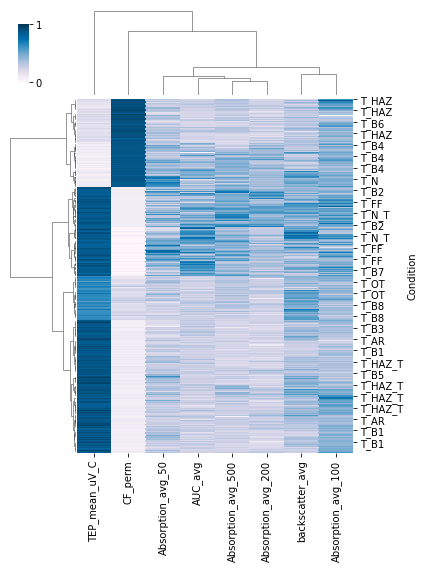

In [8]:
sns.clustermap(tube, method='ward', metric='euclidean', cmap='PuBu', figsize=(6,8), dendrogram_ratio=(0.2, 0.2), cbar_pos=(0.05, 0.85, 0.025, 0.1))

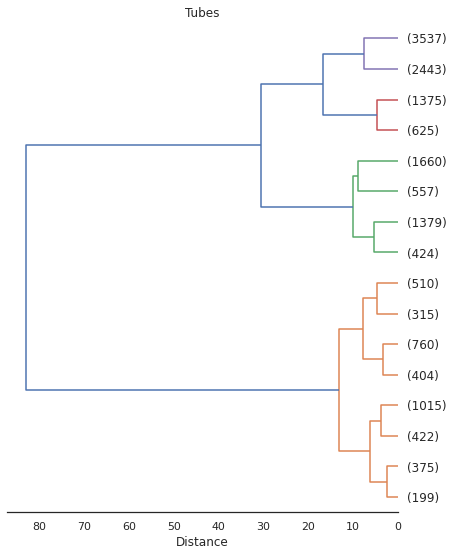

In [19]:
sns.set_theme(style="white")

Z = hierarchy.linkage(tube,
method='ward',
metric='euclidean')

ax, fig = plt.subplots(figsize=(7,9))


dendro = hierarchy.dendrogram(Z, labels=tube.index, leaf_rotation=0, orientation='left',
                              truncate_mode='level', p=3,
                              color_threshold=15
                             )
# for i, d, c in zip(dendro['icoord'], dendro['dcoord'], dendro['color_list']):
#     y = 0.5 * sum(i[1:3])
#     x = d[1]
#     #if y > 0:
#     plt.plot(x, y, 'o', c=c)
#     plt.annotate('%.3g'%x, (x, y), xytext=(5, -5),
#                  textcoords = 'offset points',
#                  va='bottom', ha='left',
#                  fontsize=10
#                 )


plt.xlabel('Distance')
plt.title('Tubes')
sns.despine(left=True)

# Cophenetic Correlation Coefficient 
Calculate the cophenetic distances between each observation in the hierarchical clustering defined by the linkage Z.

Suppose that the original data {Xi} have been modeled using a cluster method to produce a dendrogram {Ti}; that is, a simplified model in which data that are "close" have been grouped into a hierarchical tree. Define the following distance measures.
- x(i, j) = | Xi − Xj |, the ordinary Euclidean distance between the ith and jth observations.
- t(i, j) = the dendrogrammatic distance between the model points Ti and Tj. This distance is the height of the node at which these two points are first joined together.

Then, letting x ¯ {\displaystyle {\bar {x}}} {\bar {x}} be the average of the x(i, j), and letting t ¯ {\displaystyle {\bar {t}}} {\bar {t}} be the average of the t(i, j), the cophenetic correlation coefficient c is given by



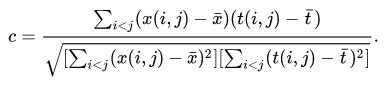

In [21]:
# The closer the value is to 1, the better the clustering preserves the original distances.
c, coph_dists = hierarchy.cophenet(Z, pdist(tube))
print(c)

0.9558795625416598


In [22]:
#HOW???
depth = 5
incons = hierarchy.inconsistent(Z, depth)
incons
# avg, std, count, inconsistency 

array([[1.23113567e-02, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.58432195e-02, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.80636219e-02, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [2.95983881e+00, 3.01931159e+00, 3.10000000e+01, 4.58152239e+00],
       [5.12436485e+00, 5.67206482e+00, 3.10000000e+01, 4.47937228e+00],
       [8.36116619e+00, 1.49941859e+01, 3.10000000e+01, 4.97801892e+00]])

In [23]:
hierarchy.maxinconsts(Z, incons)

array([0.        , 0.        , 0.        , ..., 4.58152239, 4.58152239,
       4.97801892])

In [24]:
hierarchy.maxRstat(Z, incons, 0)

array([0.01231136, 0.01584322, 0.01806362, ..., 2.95983881, 5.12436485,
       8.36116619])

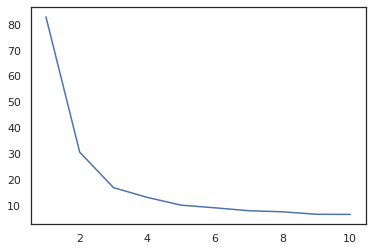

In [26]:
# plot_elbow
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

# fcluster
Cluster observation data using a given metric.

Clusters the original observations in the n-by-m data matrix X (n observations in m dimensions), using the euclidean distance metric to calculate distances between original observations, performs hierarchical clustering using the single linkage algorithm, and forms flat clusters using the inconsistency method with t as the cut-off threshold.

In [28]:
hierarchy.fclusterdata(tube, t=3, criterion='maxclust', method='ward')

array([3, 3, 3, ..., 3, 3, 3], dtype=int32)